In [7]:
%matplotlib inline
from deep_net_topics import test_deepnet, Config, plot_stats
from utils import load_data

# Simple 2-layer Deepnet

Here are parameters for the configuration tested below, this is the one that has given me the best accuracy/auc so far.

## Architecture:
**Input**: 187 Features, 88 congressman-level + 100 Topics (both proportions and dummies).

**Layer 1**: 64 units, RELU activation, L2 regularization

**Layer 2**: 16 units, RELU activation, L2 regularization

**output**: softmax activation, L2 regularization

## Hyperparameters
See the config calls before each model for the hyperparameters that are changed. Defaults are:

    batch_size = 64
    n_samples = 90795
    n_features = 187
    n_classes = 2
    max_epochs = 100
    lr = 1e-2
    l2 = 0.01
    add_data_weights = False
    layers = [Layer(64, "hidden3", tf.nn.relu, tf.nn.l2_loss),
              Layer(16, "hidden2", tf.nn.relu, tf.nn.l2_loss)]
    dropout_prob = 0.001
    verbose = True

## Notes
1. **Adding layers** doesn't imporove accuracy and causes optimizer to get stuck on local minima. Same goes for changing layer sizes.
2. **Lower learning rate** doesn't decrease final loss, higher leads to slightly worse optima.
3. **Different activation functions** on the hidden layers massively decrease performace both in terms of accuracy and auc.
4. **Sample weights**. Given how skewed the classes are it would seem that weighting predictions by the ratio of one class to another (common practice for dealing with skewed classes) may be a good idea. So far I've found that:
    * when nays are upweighted the model predicts more of them, leading to slightly worse AUC and accuracy
    * when nays are not upweighted the model has higher accuracy and AUC, making this the better option for the time being. 
    * the optimizer stops at the same local minimum in both cases. 
5. **In general**: Works as expected. Improvement in accuracy is tiny over all yea, but auc increases massively.

In [12]:
train_f, train_l, valid_f, valid_l, _, __ = load_data()
print "Training set size:", train_f.shape
print "Validation set size:", valid_f.shape

Training set size: (109816, 187)
Validation set size: (2430, 187)


Loss value: 0.279
Training: accuracy = 0.883, AUC = 0.900
Validation: accuracy = 0.823, AUC = 0.668


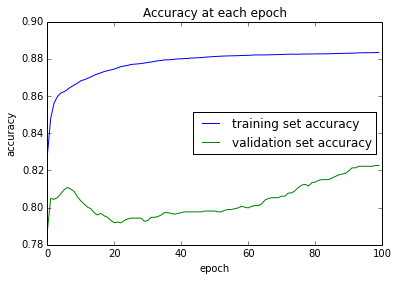

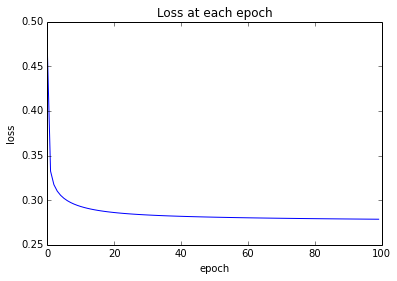

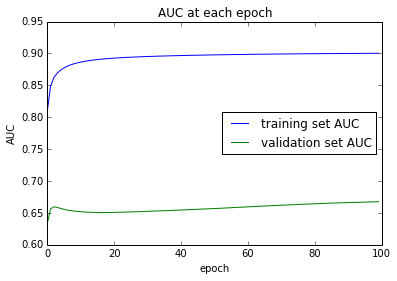

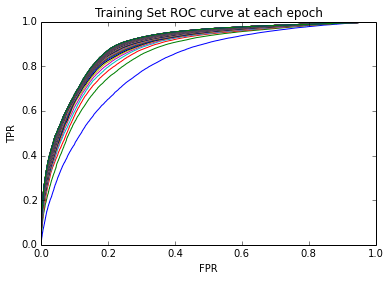

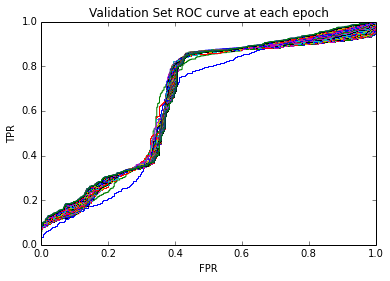

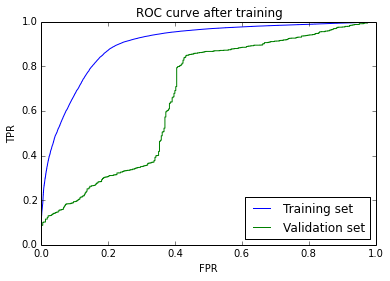

In [3]:
## No hidden layers, no regularization. I.E: simple softmax regression. 
config = Config()
config.max_epochs = 100
config.layers = []
config.dropout_prob = 0
config.verbose = False
config.l2 = 0.0001
softmax_model = test_deepnet(config)
plot_stats(softmax_model, config)

Loss value: 0.221
Training: accuracy = 0.896, AUC = 0.942
Validation: accuracy = 0.856, AUC = 0.814


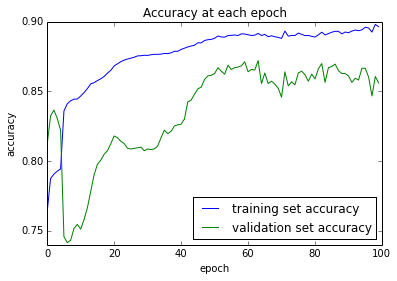

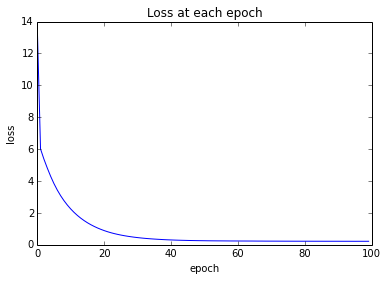

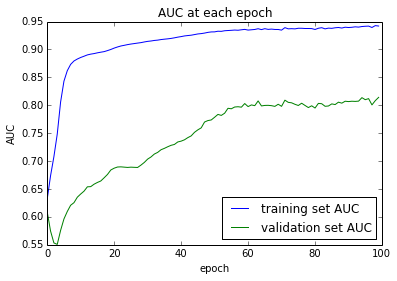

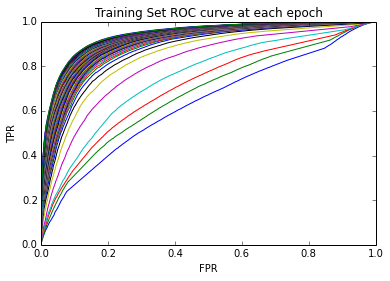

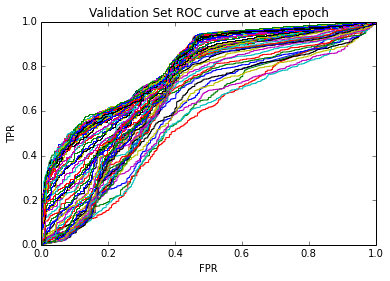

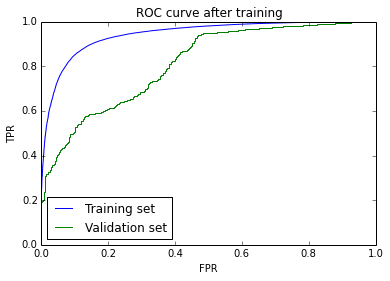

In [4]:
## Best performance so far: See default config above.
config = Config()
config.verbose = False
model = test_deepnet(config)
plot_stats(model, config)

Loss value: 0.220
Training: accuracy = 0.832, AUC = 0.913
Validation: accuracy = 0.729, AUC = 0.757


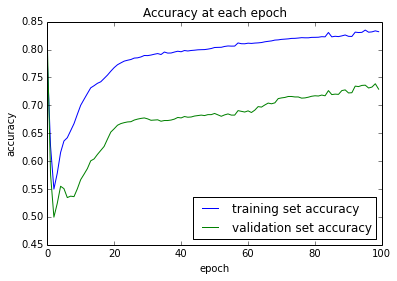

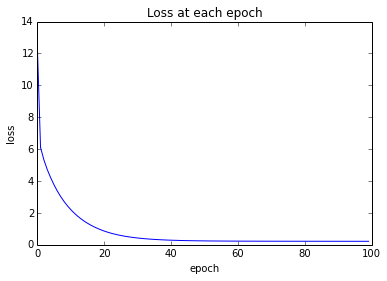

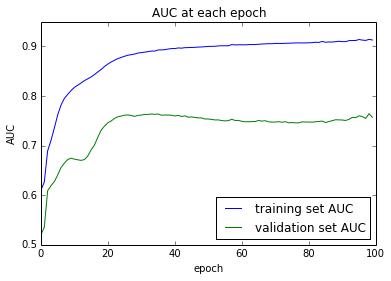

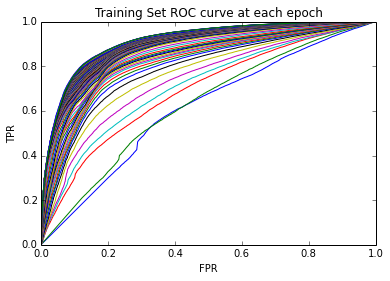

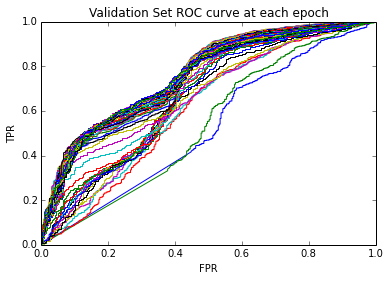

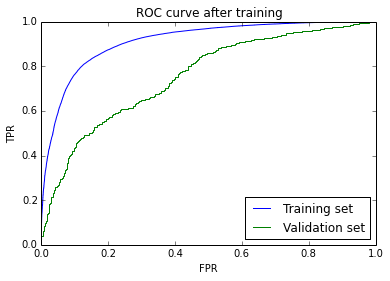

In [6]:
## upweighting nay votes
config = Config()
config.add_data_weights = True
config.verbose = False
model = test_deepnet(config)
plot_stats(model, config)

## Easy fixes
1. Implement batch renormalization (not sure if it will do anything in our case)
2. Implement test predictions
3. Find optimal sample weighting

## Ways to Improve the model

I can come up with at lest 3 ways in which we can take this forward and make it more interesting from a theoretical perspective, even if accuracy isn't improved. Keep well in mind that these 3 are not mutually exclusive and it's likely that the best possible model implements all three:

1. **Embeddings** Do the feature reduction on the bill text ourselves, by implementing an autoencoder as a step of our prediction model in a way such that embeddings are optimized for prediction, rather than text reconstruction. 

2. **Recurrent Net**: This model treats each observation as IID, which isn't the case. We could force the model to take into account both the voting history of each congressman and of all the other congressmen in relation to each specific one with a recurrent network. 

3. **Convolutional Net** In order to best model the voting dependencies of one congressman on others, we could treat all the votes on a bill as a datapoint, I.E: a matrix with congressmen on both rows and columns and wether they voted in the same way on that bill or didn't. This would effectively be the same as an image and we could use convolutions to reduce input and make predictions. Mixing this with history dependence(RNN) would make for a pretty awesome end product. 